<a href="https://colab.research.google.com/github/Rhayem1920/Dimensionality-Reduction-PCA/blob/main/Dimensionality_Reduction_PCA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Common imports
import numpy as np
import os
import pandas as pd
import seaborn as sns
font={'size': 14,
        'weight' : 'bold',
        'family':'monospace'} # weight could be book,bold etc ...
mpl.rc('font',**font)
sns.set_style('darkgrid')

# to make this notebook's output stable across runs
np.random.seed(42)


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

from sklearn.model_selection import train_test_split
X = mnist["data"]
y = mnist["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

**### 4. Kernel PCA**

  we discussed the kernel trick, a mathematical technique that implicitly
maps instances into a very high-dimensional space (called the feature space), enabling
nonlinear classification and regression with Support Vector Machines. Recall that a
linear decision boundary in the high-dimensional feature space corresponds to a
complex nonlinear decision boundary in the original space.
It turns out that the same trick can be applied to PCA, making it possible to perform
complex nonlinear projections for dimensionality reduction. This is called **KernelPCA(kPCA)**

 It is often good at preserving clusters of instances after projection, or
sometimes even unrolling datasets that lie close to a twisted manifold.


**This figure below shows the Swiss roll, reduced to two dimensions using a linear kernel
(equivalent to simply using the PCA class), an RBF kernel, and a sigmoid kernel
(Logistic).**

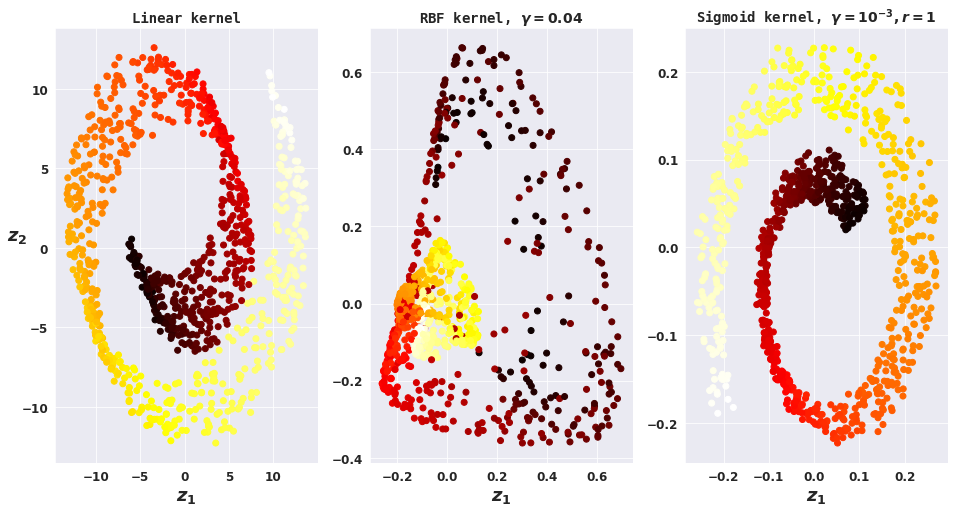

In [15]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(16, 8))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14,fontdict=font)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

**5.Hyperparameter Tuning & kernel Selection**

 As kPCA is an unsupervised learning algorithm, there is no obvious performance
measure to help you select the best kernel and hyperparameter values. However,
dimensionality reduction is often a preparation step for a supervised learning task
(e.g., classification), so you can simply use grid search to select the kernel and hyper‐
parameters that lead to the best performance on that task. For example, the following
code creates a two-step pipeline, first reducing dimensionality to two dimensions
using kPCA, then applying Logistic Regression for classification. Then it uses Grid
SearchCV to find the best kernel and gamma value for kPCA in order to get the best
classification accuracy at the end of the pipeline:

In [11]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y=t>6.9

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA
clf = Pipeline([
("kpca", KernelPCA(n_components=2)),
("log_reg", LogisticRegression())
])
param_grid=[{'kpca__gamma':np.linspace(0.03,0.05,10)    ,
             'kpca__kernel':['sigmoid','rbf'] 
             }]
grid_search=GridSearchCV(clf,param_grid,cv=3)
grid_search.fit(X,y)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                                 

In [13]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


**6.LLE**:

  Locally Linear Embedding (LLE) 8 is another very powerful nonlinear dimensionality
reduction (NLDR) technique. It is a Manifold Learning technique that does not rely
on projections like the previous algorithms. In a nutshell, LLE works by first measur‐
ing how each training instance linearly relates to its closest neighbors (c.n.), and then
looking for a low-dimensional representation of the training set where these local
relationships are best preserved (more details shortly). This makes it particularly
good at unrolling twisted manifolds, especially when there is not too much noise.
For example, the following code uses Scikit-Learn’s LocallyLinearEmbedding class to
unroll the Swiss roll.

As you can
see, the Swiss roll is completely unrolled and the distances between instances are
locally well preserved. However, distances are not preserved on a larger scale: the left
part of the unrolled Swiss roll is stretched, while the right part is squeezed. Neverthe‐
less, LLE did a pretty good job at modeling the manifold.

In [16]:
from sklearn.manifold import LocallyLinearEmbedding
lle=LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced=lle.fit_transform(X)

(-0.065, 0.055, -0.1, 0.12)

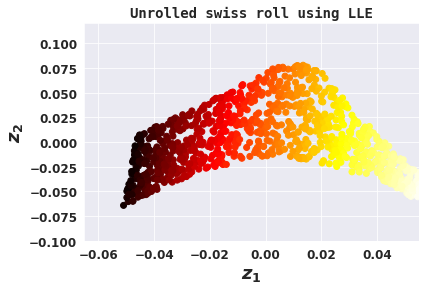

In [17]:
plt.title("Unrolled swiss roll using LLE", fontsize=14,fontdict=font)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18,fontdict=font)
plt.ylabel("$z_2$", fontsize=18,fontdict=font)
plt.axis([-0.065, 0.055, -0.1, 0.12])

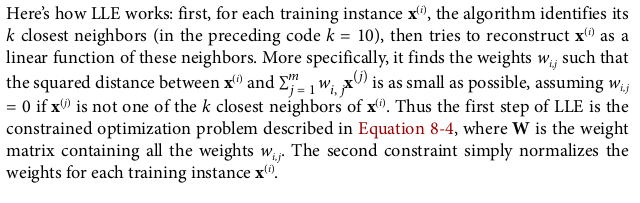

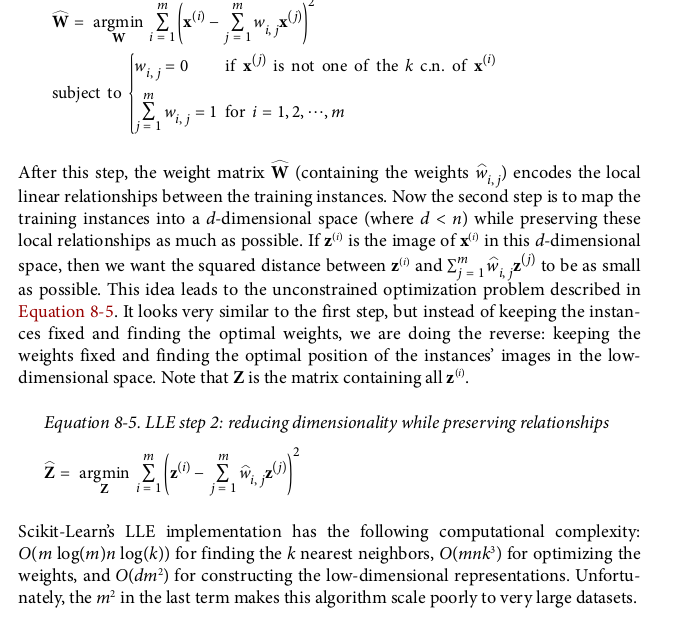